<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Acne detection using Convolutional Neural Network (Part 3/3)

---

## Contents:
- [1. Import libraries and load the model](#1.-Import-libraries-and-load-the-model)
- [2. Load Test Data](#2.-Load-Test-Data)
- [3. Test-Predictions](#3.-Test-Predictions)
- [4. Conclusion-and-Recommendation](#4.-Conclusion-and-Recommendation)
- [5. Limitation-and-future-work](#5.-Limitation-and-future-work)
- [6. Making new Prediction using random photos](#6.-Making-new-Prediction-using-random-photos)
- [7. Function for Face Detection, Capture Photo and Classification prediction](#7.-Function-for-Face-Detection,-Capture-Photo-and-Classification-prediction)

## 1. Import libraries and load the model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import pandas as pd

In [45]:
# Load the model 
model = load_model('../model/model_epoch100.h5')

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 2. Load Test Data

In [5]:
# Define labels and image size
labels = ['NON_ACNE', 'ACNE']
img_size = 150

In [6]:
# Convert image into numpy array with labels, image resize to 150X150
def get_data(data_dir):
    labels = ['NON_ACNE', 'ACNE']
    img_size = 150
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [8]:
# test data in np.array
test = get_data('../assets/assets_1/test')

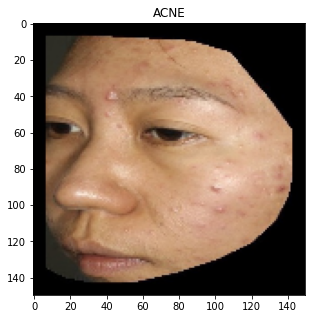

In [11]:
# plot the acne photo
plt.figure(figsize = (5,5))
plt.imshow(test[-1][0])
plt.title(labels[test[-1][1]]);

In [12]:
x_test = []
y_test = []

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_test = np.array(x_test) / 255

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## 3. Test Predictions

In [23]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_test, predictions, target_names = ['NON_ACNE','ACNE']))

              precision    recall  f1-score   support

    NON_ACNE       0.97      0.99      0.98       230
        ACNE       0.99      0.96      0.97       200

    accuracy                           0.98       430
   macro avg       0.98      0.98      0.98       430
weighted avg       0.98      0.98      0.98       430



#### Note: 
The accuracy of the model for validation images is 98% which is almost the same.

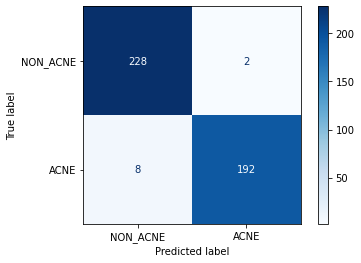

In [24]:
target_names=['NON_ACNE','ACNE']
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(include_values=True,cmap='Blues')
plt.grid(False)

In [15]:
# To load test data
path_dir=r'..\assets\assets_1\test'

In [25]:
# Dataframe for filename
data_non=pd.DataFrame(os.listdir(path_dir+"\\NON_ACNE\\"),columns=['filename'])
data=pd.DataFrame(os.listdir(path_dir+"\\ACNE\\"),columns=['filename'])
data_2=pd.concat([data_non,data],axis=0, ignore_index=True)

# Dataframe for labels
data_labels=pd.DataFrame(y_test,columns=['labels'])

# Dataframe for prediction
data_pred=pd.DataFrame(predictions0,columns=['pred'])

# Dataframe with filename,labels,prediction
df=pd.concat([data_2,data_labels,data_pred],axis=1)

In [26]:
df.head()

,filename,labels,pred
0,Non_acne (1).jpg.jpg,0,0
1,Non_acne (1002).jpg.jpg,0,0
2,Non_acne (1009).jpg.jpg,0,0
3,Non_acne (1016).jpg.jpg,0,0
4,Non_acne (1023).jpg.jpg,0,0


In [27]:
# To list the images that was wrongly predicted
diff=[]
for i in range(len(df)):
    if df.iloc[i]['labels']==df.iloc[i]['pred']:
        pass
    else:
        a=df.iloc[i]['filename']
        diff.append(a)
print(diff)

['Non_acne (223).jpg.jpg', 'Non_acne (410).jpg.jpg', 'Acne (1).jpg.jpg', 'Acne (1163).jpg.jpg', 'Acne (136).jpg.jpg', 'Acne (1442).jpg.jpg', 'Acne (1475).jpg.jpg', 'Acne (153).jpg.jpg', 'Acne (411).JPG.jpg', 'Acne (9).jpg.jpg']


#### Notes: 
By comparing the photos, the misclassification might be due to:
- Face detector failed to detect face only. As the result, model is predicting based on the face and background. 
- The model was not well trained on darker skin tones due to lack of dataset. 

## 4. Conclusion and Recommendation

The model has an accuracy of 97% on validation data and 98% on test data while the f1 score for validation data and test data are 98%. The model has a train score of 99% for both accuracy and f1 score. In order to prevent overfitting, dropout rate of 50% was introduced in the CNN model. 

Haar cascade was used in the preprocessing of the image data to crop out faces from the images. It was observed that some of the image failed to detect the faces, hence the model was training with both the faces and background as the noise. It was recommended to use other deep learning model for face detection in the pre-processing stage to improve the quality of model. 

As for the dataset, there is an imbalance data on the skin tones in the dataset as there is lesser dark skin tone in the dataset. The study from University of California San Francisco [[source]](https://www.ucsf.edu/news/2016/06/403401/darker-skin-stronger-skin-says-new-view-human-skin-color#:~:text=%E2%80%9CWork%20in%20our%20lab%20has,%2C%20MD%2C%20professor%20of%20dermatology) suggests that dark skin have a stronger skin barrier, hence this may suggest why there are lesser acne dark skin photo found. This is the limitation of the model. Alternatively, we proposed to increase synthetic data for dark skin in order to make up for the imbalance dataset. 

The model helps the company to identify acne skin consumer. This can be deployed on the website to classify the consumer skin to better recommend a more approriate skincare product online without the salesperson. Moving forward, the shopping experience can be improved to have live predictions via video instead of images. The electronic device can be placed in stores and can be helpful to the consumers especially when the salesperson was away during the store operations. 

In conclusion, the model has high accuracy and f1 score however, it is not able to work well with darker skin tone which can be further improve. 

## 5. Limitation and future work

The limitation of the model are : 
1. Face detection
2. Dark skin tone

In order to overcome the limitation, we suggest to include the following work for future development: 
1. Face detection can be improved by using MTCNN library
2. Increase darker skin tone photo 
3. SMOTE  
4. Increase images data

For better experience enhancement: 
- Live predictions via video instead of capturing images

With the proposed future plan, the model will then be deployed using Flask. 

## 6. Making new Prediction with random photos

In [31]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.get_session
cv2.ocl.setUseOpenCL(False)

In [32]:
# Function for face detection and cropping of face
def detect_face(img):
    face_img = img.copy()
    #Reads face using haarcascades 
    face_cascade = cv2.CascadeClassifier('..\haarcascades\haarcascade_frontalface_alt2.xml')
    face_rects = face_cascade.detectMultiScale(face_img,
                                               scaleFactor=1.2,
                                               minNeighbors=5,
                                               minSize=(150, 150)
                                              )
    # to add border to photo
    borderType = cv2.BORDER_CONSTANT
    
    if len(face_rects)==0:
        global faces
        faces = face_img
        #Size for border
        top = int(0.05*faces.shape[0])
        bottom = top
        left = int(0.05*faces.shape[1])
        right=left
        faces=cv2.copyMakeBorder(faces,top,bottom,left,right,borderType,None,[0,0,0])
    else: 
        for (x,y,w,h) in face_rects: 
            cv2.rectangle(face_img, (x,y), (x+w,y+h), (0,0,0), 10)
            faces = face_img[y:y + h, x:x + w]
            #Size for border
            top = int(0.05*faces.shape[0])
            bottom = top
            left = int(0.05*faces.shape[1])
            right=left
            faces=cv2.copyMakeBorder(faces,top,bottom,left,right,borderType,None,[0,0,0])
    return faces

In [33]:
# Function to predict the class of the photo taken
def return_prediction(model,detect_face,file):
    # Read the input image
    test = cv2.imread(file)
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    result = detect_face(test)
    plt.imshow(result)
    result = cv2.resize(result, (150, 150))
    result = np.asarray(result)
    result = np.expand_dims(result, axis=0)
    result = result/255
    prediction_prob = model.predict(result)
    prediction_prob=np.round(prediction_prob)
    # Output prediction
    print(f'Probability that image is acne is: {prediction_prob} ')
    return prediction_prob

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

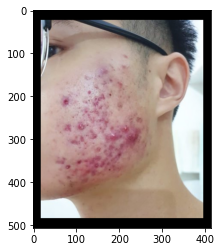

In [34]:
return_prediction(model,detect_face,'../assets/assets_testing/testing11.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

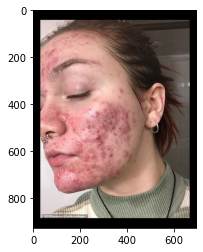

In [35]:
return_prediction(model,detect_face,'../assets/assets_testing/testing12.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

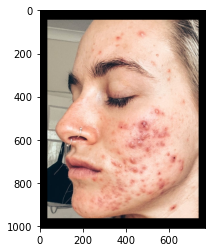

In [36]:
return_prediction(model,detect_face,'../assets/assets_testing/testing13.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

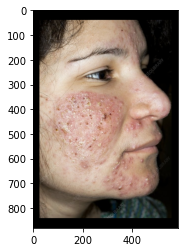

In [37]:
return_prediction(model,detect_face,'../assets/assets_testing/testing14.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

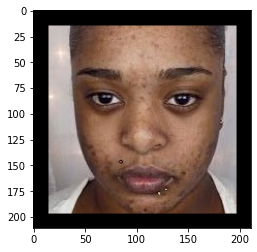

In [38]:
return_prediction(model,detect_face,'../assets/assets_testing/testing15.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

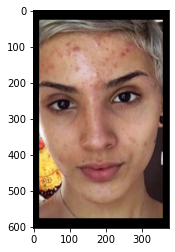

In [39]:
return_prediction(model,detect_face,'../assets/assets_testing/testing16.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

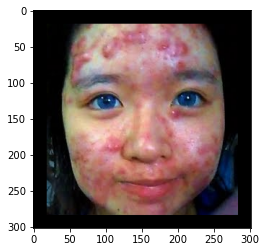

In [40]:
return_prediction(model,detect_face,'../assets/assets_testing/testing17.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

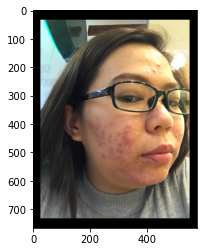

In [41]:
return_prediction(model,detect_face,'../assets/assets_testing/testing18.jpg')

Probability that image is acne is: [[0.]] 


array([[0.]], dtype=float32)

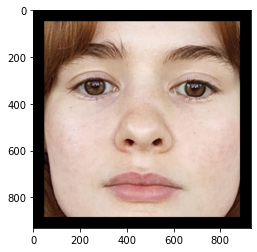

In [42]:
return_prediction(model,detect_face,'../assets/assets_testing/testing19.jpg')

Probability that image is acne is: [[1.]] 


array([[1.]], dtype=float32)

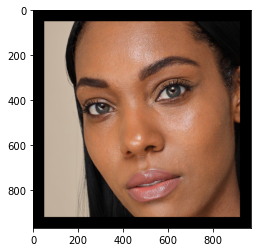

In [43]:
return_prediction(model,detect_face,'../assets/assets_testing/testing20.jpg')

#### Note: 
Model has limitation to test on darker skin tone, not enough training on darker skin. 

Probability that image is acne is: [[0.]] 


array([[0.]], dtype=float32)

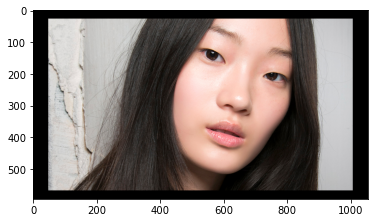

In [44]:
return_prediction(model,detect_face,'../assets/assets_testing/testing21.jpg')

## 7. Function for Face Detection, Capture Photo and Classification prediction

In [29]:
# Function for face detection and cropping of face
def detect_face(img):
    face_img = img.copy()
    #Reads face using haarcascades 
    face_cascade = cv2.CascadeClassifier('..\haarcascades\haarcascade_frontalface_alt2.xml')
    face_rects = face_cascade.detectMultiScale(face_img,
                                               scaleFactor=1.2,
                                               minNeighbors=5,
                                               minSize=(150, 150)
                                              )
    # to add border to photo
    borderType = cv2.BORDER_CONSTANT
    
    if len(face_rects)==0:
        global faces
        faces = face_img
        #Size for border
        top = int(0.05*faces.shape[0])
        bottom = top
        left = int(0.05*faces.shape[1])
        right=left
        faces=cv2.copyMakeBorder(faces,top,bottom,left,right,borderType,None,[0,0,0])
    else: 
        for (x,y,w,h) in face_rects: 
            cv2.rectangle(face_img, (x,y), (x+w,y+h), (0,0,0), 10)
            faces = face_img[y:y + h, x:x + w]
            #Size for border
            top = int(0.05*faces.shape[0])
            bottom = top
            left = int(0.05*faces.shape[1])
            right=left
            faces=cv2.copyMakeBorder(faces,top,bottom,left,right,borderType,None,[0,0,0])
    return faces

In [30]:
# Function to predict the class of the photo taken
def return_prediction(model,detect_face,file):
    # Read the input image
    test = cv2.imread(file)
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    result = detect_face(test)
    plt.imshow(result)
    result = cv2.resize(result, (150, 150))
    result = np.asarray(result)
    result = np.expand_dims(result, axis=0)
    result = result/255
    prediction_prob = model.predict(result)
    prediction_prob=np.round(prediction_prob)
    # Output prediction
    print(f'Probability that image is acne is: {prediction_prob} ')
    return prediction_prob

In [33]:
# Function to capture photo via webcam and save as .jpg file
import cv2

cam = cv2.VideoCapture(0)
img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.jpg".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()
cv2.destroyAllWindows()

opencv_frame_0.jpg written!
Escape hit, closing...


Probability that image is acne is: [[0.]] 


array([[0.]], dtype=float32)

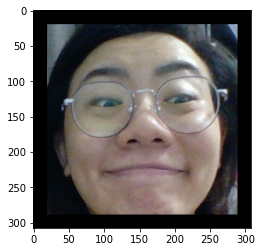

In [34]:
return_prediction(model,detect_face,img_name)